<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x450 at 0x7FB47A392050>
288000
640 450
(5, 4)
(640, 450) (640, 450)
(288000, 4)
(288000, 5, 4)
torch.Size([640, 1, 2, 5, 4])
torch.Size([1, 2, 2])
torch.Size([5, 1, 2])
torch.Size([5, 2, 2])
a:  torch.Size([5])
tensor([-1,  0,  1, -1,  1])
b:  torch.Size([5, 4])
tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])


900it [00:47, 18.82it/s]
100it [00:04, 21.69it/s]


torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])
[NbConvertApp] Converting notebook loaddata.ipynb to python
[NbConvertApp] Writing 7003 bytes to loaddata.py


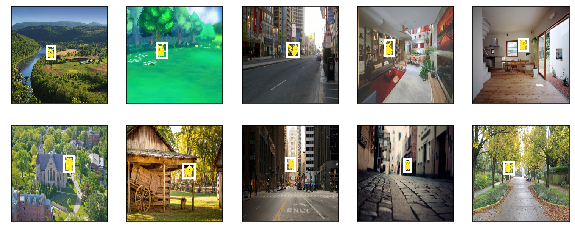

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import numpy as np
import sys
sys.path.append("/home/clw/complie/python/deep_learning/object check") 
import utils
import loaddata

# 类别预测层

In [2]:
def cls_predictor(in_channels,num_anchors, num_classes):
    return nn.Conv2d(in_channels,num_anchors*(num_classes+1),kernel_size = 3, padding=1)

# 边界框预测层

In [3]:
def bbox_preditor(in_channels,num_anchors):
    return nn.Conv2d(in_channels,num_anchors *4 , kernel_size = 3, padding =1)

In [4]:
def flatten(x):
    return  x.contiguous().view(x.shape[0], -1)

def flatten_pred(pred):
    return flatten(pred.permute((0,2,3,1)))

def concat_preds(preds):
    
    return torch.cat([flatten_pred(p) for p in preds],dim =1)


In [5]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))
Y2 = forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
print(Y1.shape, Y2.shape)


concat_preds([Y1,Y2]).shape

torch.Size([2, 55, 20, 20]) torch.Size([2, 33, 10, 10])


torch.Size([2, 25300])

# 高和宽减半

In [6]:
def down_sample_blk(in_channels,num_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels,num_channels,kernel_size=3 , padding = 1))
        blk.append(nn.BatchNorm2d(num_channels))
        blk.append(nn.ReLU())
        in_channels = num_channels
    blk.append(nn.MaxPool2d(kernel_size=3, stride=2,padding =1))
    return nn.Sequential(*blk)

In [7]:
forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape

torch.Size([2, 10, 10, 10])

# 基础网络块

In [8]:
def base_net():
    blk = []
    in_channels = 3
    for num_filters in [16,32,64]:
        blk.append(down_sample_blk(in_channels,num_filters))
        in_channels = num_filters
    return nn.Sequential(*blk)

In [9]:
forward(torch.zeros((2,3,256,256)),base_net()).shape

torch.Size([2, 64, 32, 32])

# 完整的模型

In [10]:
class GlobalMaxpool2D(nn.Module):
    def __init__(self):
        super(GlobalMaxpool2D,self).__init__()
    def forward(self,x):
        return F.max_pool2d(x, kernel_size=x.size()[2:])

In [11]:
def get_blk(i):
    if i ==0 :
        blk = base_net()
    elif i == 4 :
        blk = GlobalMaxpool2D()
    elif i ==1:
        blk = down_sample_blk(64,128)
    else :
        blk = down_sample_blk(128,128)
    return blk

In [12]:
def MultiBoxPrior(feature_map , size = [0.75,0.5,0.25],
                     ratios = [1,2,0.5]):
    pairs = []
    for r in ratios:
        pairs.append([size[0],math.sqrt(r)])
    for s in size[1:] :
        pairs.append([s,math.sqrt(ratios[0])])
    
    pairs = np.array(pairs)
    ss1 = pairs[:,0] * pairs[:,1]
    ss2 = pairs[:,0] / pairs[:,1]
    
    base_anchors = np.stack([-ss1,-ss2,ss1,ss2],axis =1)/2
    #print(base_anchors.shape)
    h,w = feature_map.shape[-2:]
    shifts_x = np.arange(0,w)/w
    shifts_y = np.arange(0,h)/h
    shift_x,shift_y = np.meshgrid(shifts_x,shifts_y)
    
    #print(shift_x.shape,shift_y.shape)
    shift_x = shift_x.reshape(-1)
    shift_y = shift_y.reshape(-1)
    shifts = np.stack((shift_x,shift_y,shift_x,shift_y),axis =1)
    #print(shifts.shape)
    anchors = shifts.reshape((-1,1,4))+base_anchors.reshape((1,-1,4))
    #print(anchors.shape)
    return torch.tensor(anchors,dtype=torch.float32).view(1,-1,4)

In [13]:
def blk_forward(X, blk, size , ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = MultiBoxPrior(Y, size = size , ratios = ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [14]:
sizes = [[0.2,0.272],[0.37,0.337],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
ratios = [[1,2,0.5]]*5
num_anchors = len(sizes[0])+len(ratios[0])-1

# 完整模型TinySSD

In [15]:
class TinySSD(nn.Module):
    def __init__(self, num_classes):
        super(TinySSD,self).__init__()
        self.num_classes = num_classes
        for i in range(5):
            setattr(self, "blk_%d"%i, get_blk(i))
            
            if i ==0 :
                in_channels = 64
            else:
                in_channels = 128
            setattr(self, "cls_%d"%i, cls_predictor(in_channels,num_anchors,num_classes))
            setattr(self, "bbox_%d"%i, bbox_preditor(in_channels, num_anchors))
    
    def forward(self,X):
        anchors, cls_preds, bbox_preds = [None]*5,[None]*5,[None]*5
        for i in range(5):
            X, anchors[i], cls_preds[i],bbox_preds[i] = blk_forward(X, getattr(self,'blk_%d'%i),sizes[i],
                                                                    ratios[i],getattr(self,"cls_%d"%i),
                                                                    getattr(self,'bbox_%d'%i))
        return (torch.cat(anchors, dim=1),
                concat_preds(cls_preds).view(X.shape[0],-1,self.num_classes+1),
                concat_preds(bbox_preds))

In [16]:
net = TinySSD(num_classes =1)
X = torch.zeros((32,3,256,256))
anchors,cls_preds, bbox_preds = net(X)

print(anchors.shape)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([1, 5444, 4])
torch.Size([32, 5444, 2])
torch.Size([32, 21776])


In [17]:
batch_size = 32
train_iter = loaddata.load_data_pikachu(batch_size)

In [19]:
net = TinySSD(num_classes =1)
trainer = torch.optim.SGD(net.parameters(),lr = 0.2, weight_decay = 5e-4)

In [20]:
cls_loss = torch.nn.CrossEntropyLoss()
bbox_loss = torch.nn.L1Loss()
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds* bbox_masks,bbox_labels * bbox_masks)
    return cls + bbox

In [21]:
def cls_eval(cls_preds, cls_labels):
    return (cls_preds.argmax(axis = -1) == cls_labels).sum().mean()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds)* bbox_masks).abs().sum().mean()

In [1]:
def train(num_epoch):
    for epoch in range(num_epoch):
        acc_sum, mae_sum, n,m =0.0,0.0,0,0
        start = time.time()
        for X,Y in train_iter:
            anchors, cls_preds,bbox_preds = net(X)
            bbox_labels,bbox_masks,cls_labels = utils.MultiBoxTarget(anchors,Y,cls_preds.permute((0,2,1)))
            l = calc_loss(cls_preds, cls_labels,bbox_preds, bbox_labels, bbox_masks)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            acc_sum += cls_eval(cls_preds, cls_labels)
            n+= cls_labels.size
            mae_sum += bbox_eval(bbox_preds,bbox_labels, bbox_masks)
            m+= bbox_labels.size
        if(epoch+1)%5 ==0:
            print('epoch %2d, class err%.2e, bbox mae%.2e, time%.1f sec'%(epoch+1, 1-acc_sum/n,mae_sum/m,time.time()-start))
    torch.save(net.state_dict(),data/SSD.pth):

In [ ]:
def predict(X):
    anchors, cls_preds, bbox_preds = net2.load_state_dict(torch.load(data/SSD.pth))